# VLM：Diffusion

In [1]:
from datasets import load_dataset
from diffusers import DiffusionPipeline
import torch
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms

/data1/zhengnanyan/miniconda3/envs/VLM310/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


# 参数配置

In [10]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 30
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 10
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()


# 加载pipeline（暂忽略）

In [43]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("/data1/zhengnanyan/huggingface/modelscope/AI-ModelScope/stable-diffusion-xl-base-1___0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

# 加载model（暂忽略）

In [25]:
# from modelscope.models import Model

# model = Model.from_pretrained('/data1/zhengnanyan/huggingface/modelscope/AI-ModelScope/stable-diffusion-xl-base-1___0')

# prompt推理

  0%|          | 0/50 [00:00<?, ?it/s]

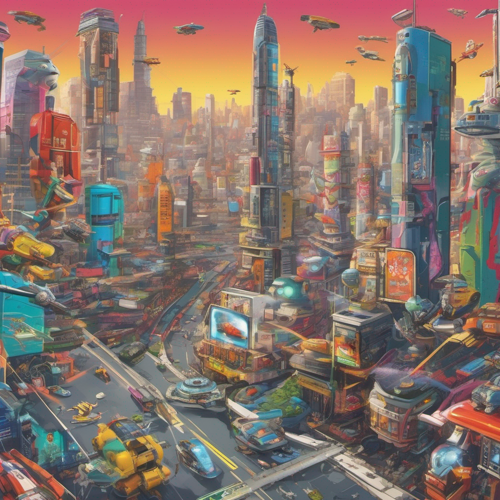

In [3]:
prompt = "Mechanical City, movie style, featuring giant posters featuring 'Python', featuring robots, flying cars, tall buildings, bright colors, and clarity"
# 机械城市，动漫风格，有python代码巨幅海报，有机器人、飞车，有高楼, 颜色明亮，画风温暖

images = pipe(prompt=prompt).images[0]
new_size = (500,500)
images.resize(new_size)

# 加载数据集

In [2]:
from datasets import load_from_disk
dataset = load_from_disk("/data1/zhengnanyan/code/VLM/data/huggan/smithsonian_butterflies_subset")
# dataset.save_to_disk('dataset/huggan/smithsonian_butterflies_subset')

In [11]:
dataset

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

In [13]:
len(dataset['image'])

1000

 Datasets使用图像功能自动解码图像数据并将其加载为PIL. Image

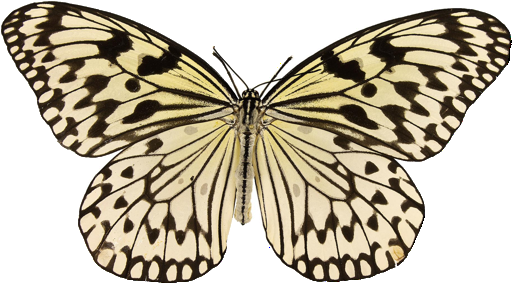

In [14]:
dataset['image'][0]

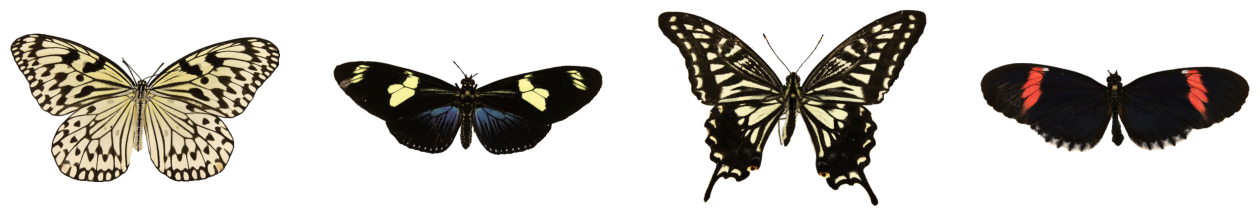

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
     axs[i].imshow(image)
     axs[i].set_axis_off()
fig.show()

# 图像预处理

由于图像大小不同，所以需要先对其进行预处理，也就是常规的图像增强：

- 调整大小将图像大小更改为配置文件中定义的图像大小—image_size。
- RandomHorizontalFlip通过随机镜像图像来增强数据集。
- Normalize对于将像素值重新缩放到[-1,1]范围内很重要，这是模型所期望的。

————————————————

原文链接：https://blog.csdn.net/qq_43456016/article/details/132263701

In [4]:
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ]
)

# set_transform方法在训练期间动态应用预处理函数：
def image_process(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(image_process)

In [8]:
# 将数据集包装在DataLoader中进行训练：
import torch.utils

train_dataloader = torch.utils.data.DataLoader(dataset,batch_size = config.train_batch_size,shuffle=True)

# 创建UNet2DModel

Diffusers 中的预训练模型可以使用我们想要的参数，从它们的模型类轻松创建。例如，要创建UNet2DModel：

In [20]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)


In [26]:
model.parameters

<bound method Module.parameters of UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): 

检查样本图像形状与模型输出形状是否匹配

In [21]:
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, timestep=0).sample.shape)


Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


# 创建scheduler

根据您是使用模型进行训练还是推理，scheduler的行为会有所不同。

在推理期间，scheduler从噪声中生成图像。

在训练期间，scheduler从扩散过程中的特定点获取模型输出或样本，并根据噪声时间表和更新规则（比如我们本系列第一张所说的step）将噪声应用于图像。


## add_noise给image添加一些随机噪声

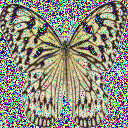

In [22]:
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

模型的训练目标是预测添加到图像中的噪声。

该步骤的损失可以通过以下方式计算，这里官方教程使用的是mse损失函数：

In [24]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

# 训练模型

## 优化器和一个学习率调度器

In [27]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

## 评估模型的方法

In [31]:
import math
import os
from diffusers import DDPMPipeline

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=2, cols=3)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch + 1:04d}.png")

In [41]:
from accelerate import Accelerator
from tqdm import tqdm

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        # if config.push_to_hub:
        #     repo_name = get_full_repo_name(Path(config.output_dir).name)
        #     repo = Repository(config.output_dir, clone_from=repo_name)
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch + 1}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                print(f'----------------------------------------------------- Evaluate Iter [{(epoch + 1) // config.save_image_epochs}] ------------------------------------------------------------------')
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                    pipeline.save_pretrained(config.output_dir)
                    


In [42]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Launching training on one GPU.


Epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]/data1/zhengnanyan/miniconda3/envs/VLM310/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 9: 100%|██████████| 63/63 [01:39<00:00,  1.58s/it, loss=0.0129, lr=9.98e-5, step=566] 


----------------------------------------------------- Evaluate Iter [1] ------------------------------------------------------------------


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 19: 100%|██████████| 63/63 [01:41<00:00,  1.60s/it, loss=0.00191, lr=8.39e-5, step=1196]


----------------------------------------------------- Evaluate Iter [2] ------------------------------------------------------------------


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 29: 100%|██████████| 63/63 [01:38<00:00,  1.56s/it, loss=0.00119, lr=4.99e-5, step=1826]


----------------------------------------------------- Evaluate Iter [3] ------------------------------------------------------------------


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 39: 100%|██████████| 63/63 [01:43<00:00,  1.65s/it, loss=0.000941, lr=1.59e-5, step=2456]


----------------------------------------------------- Evaluate Iter [4] ------------------------------------------------------------------


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 49: 100%|██████████| 63/63 [01:44<00:00,  1.66s/it, loss=0.000859, lr=1.39e-7, step=3086]


----------------------------------------------------- Evaluate Iter [5] ------------------------------------------------------------------


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 50: 100%|██████████| 63/63 [02:32<00:00,  2.42s/it, loss=0.0051, lr=0, step=3149]
